# Pet Adoption Prediction

The purpouse of this project is to predict adoption for pets, based on the data extracted from the pet’s listing on PetFinder.my (Malaysia’s leading online animal welfare platform) and available on [https://www.kaggle.com/c/petfinder-adoption-prediction/data].

The data includes text, tabular and image data for the pets. Exploratory data analysis can be used to derive relationships between the adoption speed and the various parameters available from the pet’s profile and suggest improvements to the profiles that would increase the animal’s adoptability. 
Some profiles represent a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted.

## Data Fields
- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese

While it might be beneficial to predict the various categories of speed, for this project we exclusively focused on predicting those animals in Speed Category 4 (no adoption after 100 days) to identify animals with the highest risk of being euthanized.


# Importing the Data

In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Understanding the data

# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter
import scipy.stats as ss


# Define files and directories
os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone1/')
         
# Create DataFrame with training and testing data 
df_train = pd.read_csv('./train/train.csv')
df_test = pd.read_csv('./test/test.csv')

# Import Malaysian states labels
state_labels = pd.read_csv('StateLabels.csv')

# Import breed labels decoder for petfinder data 
df_breedlabels = pd.read_csv('breed_labels_Original.csv', index_col = 'BreedID' )
df_breedlabelsdogs = pd.read_csv('breed_labels_dogs.csv', index_col = 'BreedID' )#dog labels had to be adjusted to match data in dog traits df


# Import breed traits data 
df_breedtraits = pd.read_csv('dogtraits_main.csv')
df_breedtraits.columns = df_breedtraits.columns.str.replace(' ', '')#remove spaces from column names

# Exploring Imported Data

In [2]:
# First look at imported data: select sample of 3 random rows 
df_train.sample(n=3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
1539,2,PANDA,1,265,0,1,1,7,0,1,...,1,1,0,41326,98b3e1d6395d5f8c3cf10b848e4ae0c4,0,hi. ada org buang anak kucing depan rumah saya...,58c5f739c,1.0,1
12600,1,NaN,2,307,0,2,2,0,0,2,...,1,1,0,41324,59dd5e67149bb16fade497f16f091194,0,Kindly contact us if anyone is interested in a...,fc7f99ad7,1.0,4
6214,2,Tumbles,2,299,266,2,1,6,0,1,...,1,1,0,41327,8c6529c279739d3ba5fc00e6e2e81ab6,1,"Tumbles is a cuddly, playful, joy-filled kitte...",94a0eb345,5.0,1


In [3]:
# Print train DataFrame summary
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [4]:
# Print test DataFrame summary
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3972 entries, 0 to 3971
Data columns (total 23 columns):
Type            3972 non-null int64
Name            3561 non-null object
Age             3972 non-null int64
Breed1          3972 non-null int64
Breed2          3972 non-null int64
Gender          3972 non-null int64
Color1          3972 non-null int64
Color2          3972 non-null int64
Color3          3972 non-null int64
MaturitySize    3972 non-null int64
FurLength       3972 non-null int64
Vaccinated      3972 non-null int64
Dewormed        3972 non-null int64
Sterilized      3972 non-null int64
Health          3972 non-null int64
Quantity        3972 non-null int64
Fee             3972 non-null int64
State           3972 non-null int64
RescuerID       3972 non-null object
VideoAmt        3972 non-null int64
Description     3971 non-null object
PetID           3972 non-null object
PhotoAmt        3972 non-null float64
dtypes: float64(1), int64(18), object(4)
memory usage: 713.

In [5]:
df_train.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [6]:
#concatenate training and testing data
df_adoption_full = pd.concat([df_train, df_test], sort=False)
df_adoption_full.tail(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
3969,2,NaN,5,300,0,3,1,2,4,2,...,1,6,0,41401,30aa45fdbe45e39d5614ef583b569073,0,these cat's mother was killed when they was ne...,399013029,1.0,NaN
3970,1,Smokey,24,307,0,2,5,7,0,2,...,1,1,0,41325,087903c2819a6297519c93d962b488d5,0,"smokey is good family pet. very obedient,so lo...",fd80b8c80,3.0,NaN
3971,2,NaN,1,266,0,3,1,7,0,1,...,1,6,0,41326,041876679ae0261e3ee4aefe9e66316f,0,Found abandoned with the mother at nearby shop...,493ed84ae,1.0,NaN


# Checking for missing values

In [7]:
#Function that calculates percentage of missing data per column
def missingData(dataframe):
    missing = False
    for item in (dataframe.isnull().sum()).iteritems():
        if item[1] > 0:
            print('Missing Data percentage for '+item[0]+' is {:2.2%}'.format((item[1]/dataframe.shape[0])) )
            missing = True
    if not missing:
        print('Found no missing values.')            

In [8]:
missingData(df_train)

Missing Data percentage for Name is 8.38%
Missing Data percentage for Description is 0.08%


In [9]:
missingData(df_test)

Missing Data percentage for Name is 10.35%
Missing Data percentage for Description is 0.03%


In [10]:
missingData(df_breedtraits)

Found no missing values.


In [11]:
missingData(df_breedlabelsdogs)

Found no missing values.


In [12]:
# To enable us to explore numeric relationships in more depth, the number of days until adoption will also
# be added using an average value of number of days until adoption for each category in AdoptionSpeed
# Since category 4 doesn't provide us with a date range like the other categories 150 days are assumed, which might lead to some 
# innacuracy when exploring relationships between variables for pets in category 4

DaysToAdoption = {0:0, 1:4, 2:19, 3:61, 4:150}

df_train['DaysToAdoption'] = df_train['AdoptionSpeed'].map(DaysToAdoption)

df_train[['DaysToAdoption','AdoptionSpeed']].head(10)

,DaysToAdoption,AdoptionSpeed
0,19,2
1,0,0
2,61,3
3,19,2
4,19,2
5,19,2
6,4,1
7,61,3
8,4,1
9,150,4


In [13]:
# An additional column (NoAdoption) will be created to easily identify those pets in category 4 that were not adopted after 100 days
df_train['NoAdoption'] = df_train['AdoptionSpeed'].apply(lambda x: True if x == 4 else False)

df_train[['NoAdoption','AdoptionSpeed']].head(10)

,NoAdoption,AdoptionSpeed
0,False,2
1,False,0
2,False,3
3,False,2
4,False,2
5,False,2
6,False,1
7,False,3
8,False,1
9,True,4


## Merging PetFinder and Dog Breed Traits data

In [14]:
#creating a dataframes of dogs only
df_adoption_dogs = df_train[df_train['Type'] == 1]

# adding breed label data to the adoption data based on Breed1 and Breed2
df_adoption_breeds = pd.merge(df_adoption_dogs, df_breedlabelsdogs, how ='left', left_on='Breed1', right_on='BreedID')
df_adoption_breeds = pd.merge(df_adoption_breeds, df_breedlabelsdogs, how='left', left_on='Breed2', right_on='BreedID', suffixes=('_1', '_2'),)

df_adoption_breeds.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'DaysToAdoption', 'NoAdoption', 'BreedLabel_1', 'BreedLabel_2'],
      dtype='object')

In [15]:
#adding traits data based on 'Breed1' then on 'Breed2'
df_adoption_traits = pd.merge(df_adoption_breeds, df_breedtraits, how='left', left_on='BreedLabel_1', right_on='BreedName')

df_adoption_traits = pd.merge(df_adoption_traits, df_breedtraits, how='left', left_on='BreedLabel_2', right_on='BreedName', suffixes=('_1', '_2'))

#remove data for which breed1 and breed2 traits are missing 
df_adoption_traits = df_adoption_traits[(df_adoption_traits['BreedName_1'].notnull()) | (df_adoption_traits['BreedName_2'].notnull())]

# Data Visualization

### Description of Adoption Speeds
- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

### Overall Distribution of Adoption Speeds in Training Set

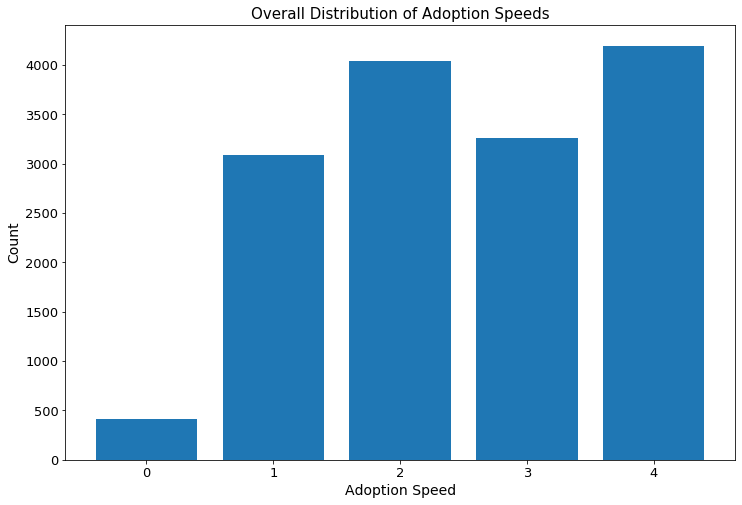

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(df_train['AdoptionSpeed'], bins=[0,1,2,3,4,5] ,rwidth = 0.8, align = 'left')
plt.yticks(fontsize=13)
plt.xticks([0,1,2,3,4], fontsize=13)
plt.title('Overall Distribution of Adoption Speeds', fontsize=15)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Adoption Speed', fontsize=14)
plt.show()

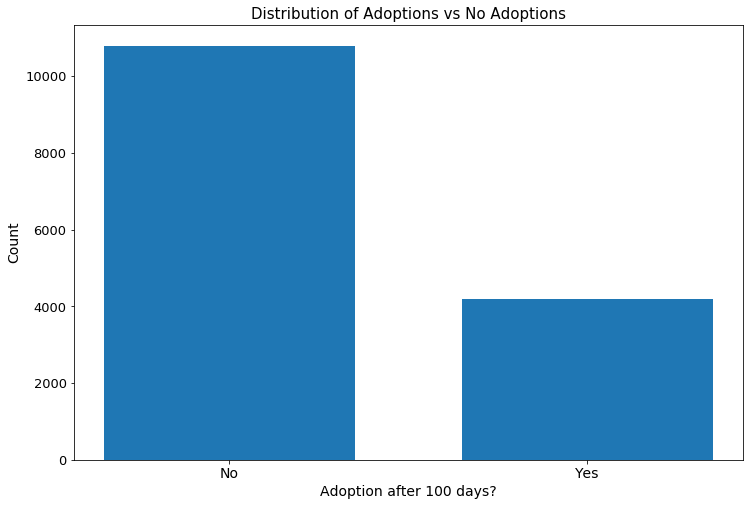

In [17]:
plt.figure(figsize=(12, 8))
plt.hist(df_train['NoAdoption'], bins=[0,1,2] , rwidth = .7, align='left')
plt.yticks(fontsize=13)
plt.title('Distribution of Adoptions vs No Adoptions', fontsize=15)
plt.xticks([0,1], labels=['No','Yes'], fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Adoption after 100 days?', fontsize=14)
plt.show()

### Is there a difference in adoption rates for cats vs dogs and males vs females?

In [18]:
df_train['Type'] = df_train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

gender_dict = {1:'Male', 2:'Female'}
df_train_gender = df_train
df_train_gender['Gender']= df_train['Gender'].map(gender_dict)
df_train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,DaysToAdoption,NoAdoption
0,Cat,Nibble,3,299,0,Male,1,7,0,1,...,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,19,False
1,Cat,No Name Yet,1,265,0,Male,1,2,0,2,...,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0,False
2,Dog,Brisco,1,307,0,Male,2,7,0,2,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,61,False
3,Dog,Miko,4,307,0,Female,1,2,0,2,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,19,False
4,Dog,Hunter,1,307,0,Male,1,0,0,2,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,Cat,NaN,2,266,0,NaN,1,0,0,2,...,0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,2,19,False
14989,Cat,Serato & Eddie,60,265,264,NaN,1,4,7,2,...,0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,4,150,True
14990,Cat,Monkies,2,265,266,NaN,5,6,7,3,...,30,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,3,61,False
14991,Cat,Ms Daym,9,266,0,Female,4,7,0,1,...,0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,4,150,True


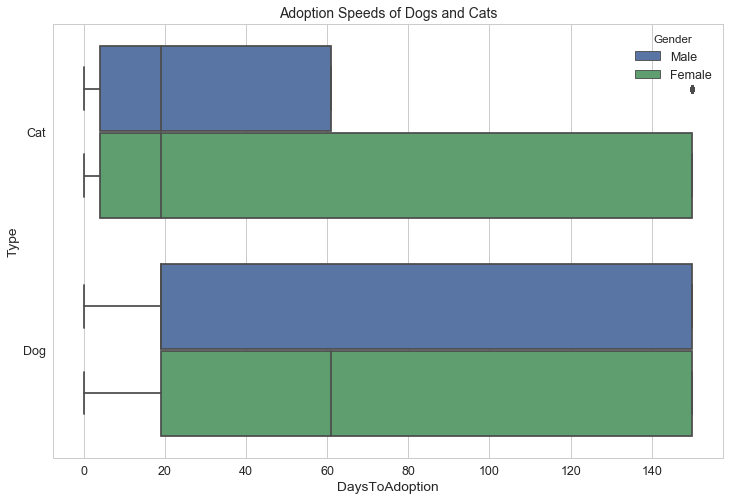

In [19]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
sns.boxplot(x ='DaysToAdoption', y='Type', hue='Gender', data=df_train_gender)
plt.title('Adoption Speeds of Dogs and Cats', fontsize=14)
plt.show()

Males seem to get adoped faster than females for both cats and dogs

In [20]:
#We can perform a t-test and calculate p-values to verify that sex and type are indeed statistically significant factors impacting adoption
from scipy.stats import ttest_ind

females = df_train.loc[df_train['Gender'] == 'Female','DaysToAdoption']
males = df_train.loc[df_train['Gender'] == 'Male','DaysToAdoption']

stat, p = ttest_ind(females, males) 
    
if p < 0.05:#using 95% confidence interval, can be adjusted for different values
            print("There is a statistically significant difference between males and females.\nP-value:{p}.\n".format(p =p))
        
cats = df_train.loc[df_train['Type'] == 'Dog','DaysToAdoption']
dogs = df_train.loc[df_train['Type'] == 'Cat','DaysToAdoption']

stat, p = ttest_ind(females, males) 
    
if p < 0.05:#using 95% confidence interval, can be adjusted for different values
            print("There is a statistically significant difference between cats and dogs.\nP-value:{p}.\n".format(p =p))        
        

There is a statistically significant difference between males and females.
P-value:4.316224264362629e-11.

There is a statistically significant difference between cats and dogs.
P-value:4.316224264362629e-11.



### Are younger pets more likely to get adopted quickly?

In [21]:
pd.crosstab(df_train.AdoptionSpeed, df_train.Age)

Age,0,1,2,3,4,5,6,7,8,9,...,132,135,144,147,156,168,180,212,238,255
AdoptionSpeed,,,,,,,,,,,,,,,,,,,,,
0,10,54,115,44,24,7,20,7,4,5,...,0,0,0,0,0,0,0,0,0,0
1,50,643,865,408,211,100,80,43,36,24,...,1,0,0,1,0,0,0,0,0,0
2,44,754,1120,586,265,157,117,59,68,51,...,1,0,1,0,1,0,0,0,0,0
3,39,511,783,458,260,135,115,62,70,31,...,3,1,1,0,0,1,1,2,0,0
4,36,342,620,470,349,196,226,110,131,73,...,3,0,2,0,0,0,1,1,1,2


Converting the pet's age into years will make the data easier to read. 
255 months is the maximum and seems pretty old at 21 years and change, but with the oldest recorded cat at 38 yo and the oldest recorded dog at 29yo, we cannot rule it out.

In [22]:
ss.pointbiserialr(df_train['NoAdoption'], df_train['Age'])

PointbiserialrResult(correlation=0.11043932612065595, pvalue=6.616521713632641e-42)

In [23]:
ss.pearsonr(df_train['AdoptionSpeed'], df_train['Age'])

(0.1005099328830761, 5.706872051967977e-35)

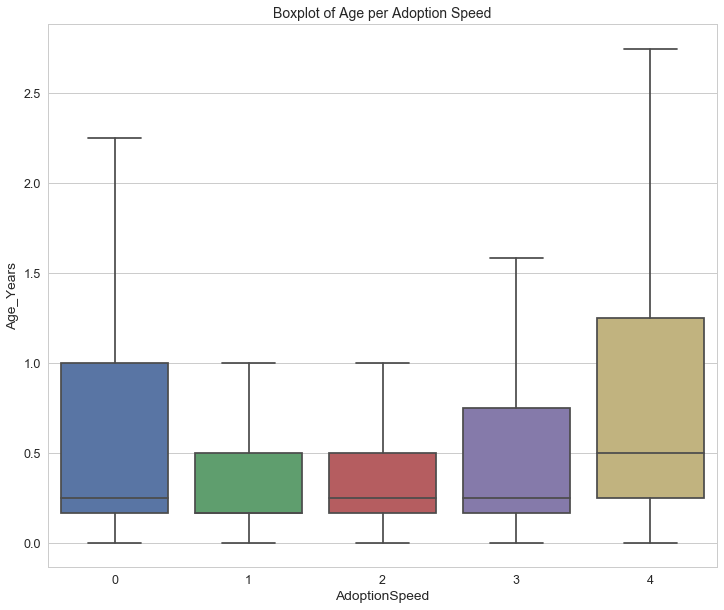

In [24]:
df_train['Age_Years']= df_train['Age']/12

plt.figure(figsize=(12, 10))
sns.boxplot(x ='AdoptionSpeed', y='Age_Years', data=df_train, showfliers = False)#outliers are hidden to show trends more clearly
plt.title('Boxplot of Age per Adoption Speed', fontsize=14);

### How much does Health Impact Adoption Speed?

In [25]:
#Health status 1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified
health_summary = pd.crosstab(df_train.AdoptionSpeed, df_train.Health).transpose()
health_summary['Total'] = health_summary.sum(axis=1)
health_summary.reset_index()

AdoptionSpeed,Health,0,1,2,3,4,Total
0,1,392,2999,3925,3150,4012,14478
1,2,17,89,106,98,171,481
2,3,1,2,6,11,14,34


In [26]:
#The great majority of animals are "Healthy"
#Below we add columns calculating the percentage of animals in each adoption speed category per health status

for column in health_summary.columns[:-1]:
    health_summary[str(column)+'_%'] = (health_summary[column]/health_summary['Total']*100).round(2)

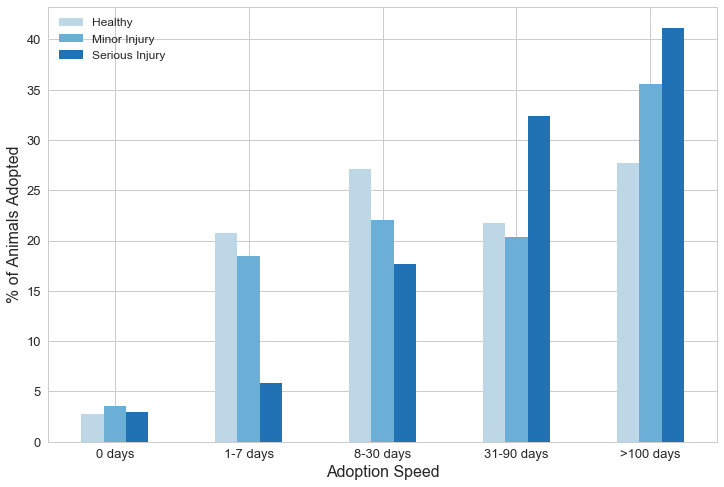

In [27]:
my_colors = ['#bdd7e7','#6baed6','#2171b5','#08519c']
plot = health_summary.iloc[:,-5:].transpose().plot.bar(figsize=(12,8), rot=0, fontsize=13, color=my_colors)
plot.set_xticklabels(('0 days','1-7 days','8-30 days','31-90 days','>100 days'))
plot.set_ylabel('% of Animals Adopted', fontsize=16)
plot.set_xlabel('Adoption Speed', fontsize=16);
plot.legend(['Healthy', 'Minor Injury', 'Serious Injury'], fontsize=12);

Over 40% of animals with serious injuries are not adopted after 100 days, for healthy animals that number is only at 28% . Minor injuries also seems to impact the rate at which animals don't get adopted. To decide whether the observed differences are statistically significant we perform a Tukey test below.

In [28]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [29]:
# Set up the data for comparison (creates a specialised object)
df_train['Health'].replace({1: 'Healthy', 2: 'Minor Injury', 3: 'Serious Injury'}, inplace= True)

MultiComp = MultiComparison(df_train['DaysToAdoption'],
                            df_train['Health'])

# Print the comparisons

print(MultiComp.tukeyhsd().summary())

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1        group2     meandiff  lower    upper  reject
------------------------------------------------------------
  Healthy     Minor Injury   9.8641   3.4739  16.2542  True 
  Healthy    Serious Injury 24.2704   0.5973  47.9434  True 
Minor Injury Serious Injury 14.4063  -10.0604 38.8731 False 
------------------------------------------------------------


There is a statistically significant difference between healthy pets and injured pets, but not between animals with serious vs. minor injuries.

### Are dogs with identified breeds more likely to get adopted than those labeled as "Mixed Breed"?

In [30]:
#Performing chi square test on each breed to see if we can limit the number of breeds to those that
#are statistically significant from others

from statsmodels.stats.proportion import proportions_chisquare

df_train_dogs = df_train[df_train['Type']== 'Dog']

breeds = df_train_dogs['Breed1'].unique()
significant_breeds = {}#this dict will store the labels of breed that are statistically significant different from others

#the loop below calculates the p_value for each individual breed
for breed in breeds:
    df_breed = df_train.loc[df_train['Breed1'] == breed,'NoAdoption']
    df_other_breeds = df_train.loc[df_train['Breed1'] != breed,'NoAdoption']
    
    breed_not_adopted = df_breed.sum()
    other_dogs_not_adopted = df_other_breeds.sum()
    count = np.array([breed_not_adopted, other_dogs_not_adopted])
    
    nobs_breed = len(df_breed)
    nobs_other_breeds = len(df_other_breeds)
    nobs = np.array([nobs_breed, nobs_other_breeds])
    
    pval = proportions_chisquare(count, nobs)[1]
    
    if nobs_breed>= 5:# observed frequency should be at least 5
        if pval < 0.05:#using 95% confidence interval, can be adjusted for different values
            significant_breeds[breed] = {'p_value':pval}
    
print(significant_breeds.keys())

dict_keys([307, 218, 189, 205, 141, 207, 109, 103, 78, 20, 69, 179, 152, 60, 239, 169])


In [31]:
#For this analysis we will be using "Breed1" dog breed values 

breed_adoption_rates = pd.pivot_table(df_adoption_breeds[['AdoptionSpeed','BreedLabel_1']], index=['BreedLabel_1'], columns=['AdoptionSpeed'], aggfunc=len, fill_value=0)

breed_adoption_rates['BreedTotal'] = breed_adoption_rates.sum(axis = 1)

for column in breed_adoption_rates.columns[:-1]:
    breed_adoption_rates[str(column)+'_%'] = (breed_adoption_rates[column]/breed_adoption_rates['BreedTotal']*100).round(2)

breed_adoption_rates = breed_adoption_rates.sort_values(by='BreedTotal', ascending=False)

breed_adoption_rates.head(30)

AdoptionSpeed,0,1,2,3,4,BreedTotal,0_%,1_%,2_%,3_%,4_%
BreedLabel_1,,,,,,,,,,,
Mixed Breed,81,859,1575,1381,2027,5923,1.37,14.50,26.59,23.32,34.22
Labrador Retriever,7,45,68,74,36,230,3.04,19.57,29.57,32.17,15.65
Shih Tzu,8,66,53,35,27,189,4.23,34.92,28.04,18.52,14.29
Poodle,16,51,47,30,25,169,9.47,30.18,27.81,17.75,14.79
Airedale Terrier,1,29,46,52,34,162,0.62,17.90,28.40,32.10,20.99
Golden Retriever,10,44,43,33,21,151,6.62,29.14,28.48,21.85,13.91
German Shepherd Dog,1,24,36,23,16,100,1.00,24.00,36.00,23.00,16.00
German Spitz,3,12,26,29,23,93,3.23,12.90,27.96,31.18,24.73
Beagle,7,25,15,29,14,90,7.78,27.78,16.67,32.22,15.56


From the summary table above several things become clear:
- Dogs simply labelled as 'mixed breed' are the most abundant and constitute over 1/3 of all dogs in the dataset
- Dogs labeled as 'mixed breed' have one of the highest percentages of no adoption after 100 days at 34.2%
- Poodles and the Standard Schnauzers have high rates of same day adoption at 9.5 and 8.7%

For a more clear summary, 'mixed breed' animals are compared against the overall average of all other breeds below:

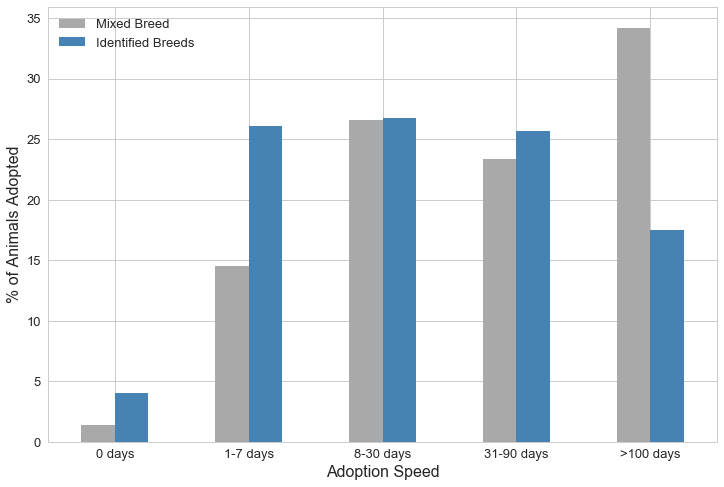

In [32]:
comparison = breed_adoption_rates.iloc[0:1,0:6]#mixed breed row
other_breed_rates = breed_adoption_rates.iloc[1:,0:6].sum()
comparison = comparison.append(other_breed_rates.rename('Identified Breeds'))

for column in comparison.columns[:-1]:
    comparison[str(column)+'_%'] = (comparison[column]/comparison['BreedTotal']*100).round(2)
    
comparison = (comparison.iloc[:,-5:]).transpose()

my_colors = ['darkgrey','steelblue']
#my_colors = ['silver','black']
plot = comparison.plot.bar(figsize=(12,8), rot=0, fontsize=13, color=my_colors)
plot.set_xticklabels(('0 days','1-7 days','8-30 days','31-90 days','>100 days'))
plot.set_ylabel('% of Animals Adopted', fontsize=16)
plot.set_xlabel('Adoption Speed', fontsize=16)
plot.legend(fontsize=13);

To determine whether this difference is statistically significant we perform a chi-squared test for adoption speed between MixedBreed animals and identified breed animals.

In [33]:
contingency_table = breed_adoption_rates.iloc[0:1,0:5]
contingency_table = contingency_table.append(breed_adoption_rates.iloc[1:,0:5].sum().rename('Identified Breeds'))
contingency_table

AdoptionSpeed,0,1,2,3,4
BreedLabel_1,,,,,
Mixed Breed,81,859,1575,1381,2027
Identified Breeds,89,576,589,566,385


In [34]:
#Below we perform a chi-squared test to verify whether the observed difference in Mixed Breeds vs Identified Breed is statistically significant

# chi-squared test
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(contingency_table)
print('dof=%d' % dof)
print(expected)

# interpreting test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpreting p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=4
[[ 123.8816437  1045.70681594 1576.94045276 1418.80917815 1757.66190945]
 [  46.1183563   389.29318406  587.05954724  528.19082185  654.33809055]]
probability=0.950, critical=9.488, stat=333.457
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


### What are the most popular dog breeds?

In [35]:
breed_names_dict = df_breedlabelsdogs.to_dict()['BreedLabel']
significant_breeds_names=[]

for item in significant_breeds.keys():
    breed_name =  breed_names_dict.get(item)
    if breed_name != None:
        if breed_name not in significant_breeds_names:
            significant_breeds_names.append(breed_name)

        
significant_breed_adoption_rates = breed_adoption_rates.loc[significant_breeds_names].sort_values(by='4_%', ascending=False)
significant_breed_adoption_rates

AdoptionSpeed,0,1,2,3,4,BreedTotal,0_%,1_%,2_%,3_%,4_%
BreedLabel_1,,,,,,,,,,,
Mixed Breed,81,859,1575,1381,2027,5923,1.37,14.50,26.59,23.32,34.22
Airedale Terrier,1,29,46,52,34,162,0.62,17.90,28.40,32.10,20.99
Miniature Pinscher,1,15,20,20,11,67,1.49,22.39,29.85,29.85,16.42
German Shepherd Dog,1,24,36,23,16,100,1.00,24.00,36.00,23.00,16.00
Labrador Retriever,7,45,68,74,36,230,3.04,19.57,29.57,32.17,15.65
Beagle,7,25,15,29,14,90,7.78,27.78,16.67,32.22,15.56
Poodle,16,51,47,30,25,169,9.47,30.18,27.81,17.75,14.79
Shih Tzu,8,66,53,35,27,189,4.23,34.92,28.04,18.52,14.29
Golden Retriever,10,44,43,33,21,151,6.62,29.14,28.48,21.85,13.91


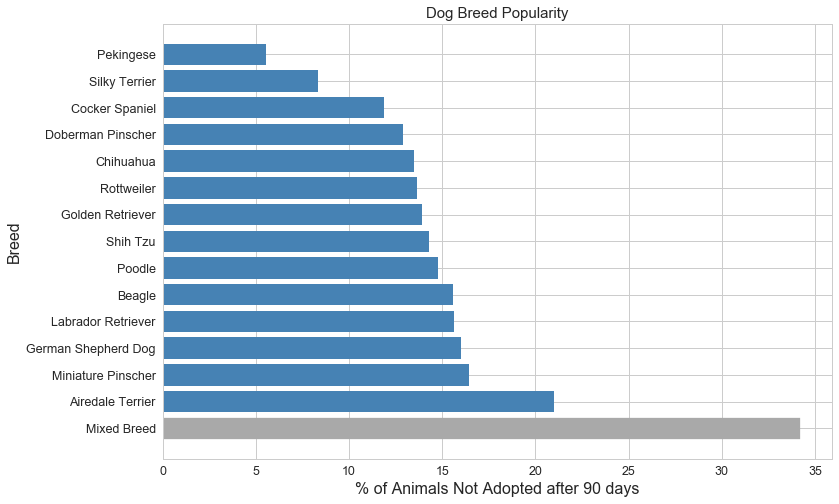

In [36]:
df = significant_breed_adoption_rates[['4_%']]
plt.figure(figsize=(12,8))
plot = plt.barh(range(len(df)),df['4_%'], color='steelblue')
plot[0].set_color('darkgrey')
#plt.figure()
plt.title('Dog Breed Popularity')
plt.ylabel('Breed', fontsize=16)
plt.xlabel('% of Animals Not Adopted after 90 days', fontsize=16)
plt.yticks(ticks =range(len(df)), labels=list(df.index));

### Is there a difference in adoption rates for different sized dogs?

In [37]:
#MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large)
#Cats' sizes don't vary as much so they are excluded from this comparison

size_summary = pd.crosstab(df_adoption_dogs.MaturitySize, df_adoption_dogs.AdoptionSpeed)
size_summary['Total'] = size_summary.sum(axis=1)
size_summary

AdoptionSpeed,0,1,2,3,4,Total
MaturitySize,,,,,,
1,50,283,310,245,335,1223
2,99,978,1652,1541,1857,6127
3,21,168,192,157,222,760
4,0,6,10,6,0,22


In [38]:
#Below we add columns calculating the percentage of animals in each adoption speed category per size
for column in size_summary.columns[:-1]:
    size_summary[str(column)+'_%'] = (size_summary[column]/size_summary['Total']*100).round(2)

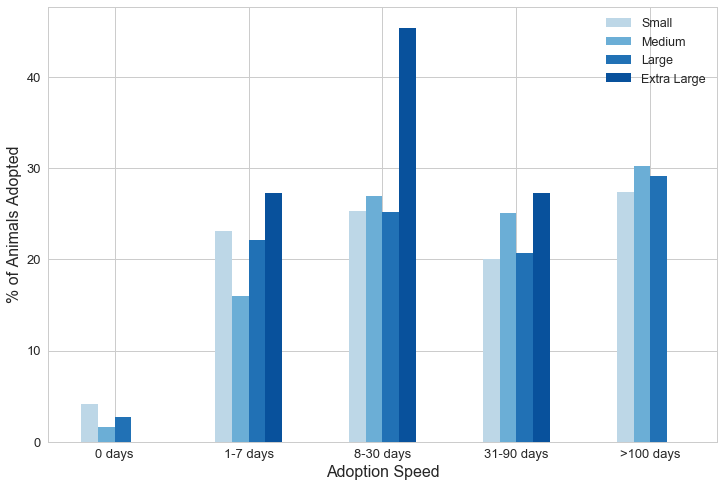

In [39]:
my_colors = ['#bdd7e7','#6baed6','#2171b5','#08519c']
plot = size_summary.iloc[:,-5:].transpose().plot.bar(figsize=(12,8), rot=0, fontsize=13, color=my_colors)
plot.set_xticklabels(('0 days','1-7 days','8-30 days','31-90 days','>100 days'))
plot.set_ylabel('% of Animals Adopted', fontsize=16)
plot.set_xlabel('Adoption Speed', fontsize=16)
plot.legend(['Small', 'Medium', 'Large', 'Extra Large']);

There doesn't seem to be a real correlation between dog size and adoption speed, our p-value for this feature in our logistic regression model later on confirms this hypothesis

### Which features have the strongest correlation to adoption speed?

In [40]:
#Defining numerical and categorical features
categorical = ['Breed1','Breed2', 'Gender', 'Color1', 'MaturitySize', 'FurLength','Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State', 'StateName','Type','NoAdoption']
categorical_multilevel = ['Breed1','Breed2', 'Gender', 'Color1', 'MaturitySize', 'FurLength','Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State', 'StateName']
categorical_binomial = ['Type', 'NoAdoption']
numerical = ['Age', 'Fee', 'Adaptability_1', 'AllAroundFriendliness_1','HealthGrooming_1', 'Trainability_1', 'ExerciseNeeds_1', 'Quantity', 'PhotoAmt']
target = ['NoAdoption']

In [41]:
#this function is used to get correlation between categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [42]:
#this function is used for correlation between multi-level categorical features (non-binomial) and numerical features
# extracted from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [43]:
#Dropping all ID features and columns derived from AdoptionSpeed
df_train = pd.read_csv('./train/train.csv')
df_train['NoAdoption'] = df_train['AdoptionSpeed'].apply(lambda x: True if x == 4 else False)
data = df_train.drop(columns=['AdoptionSpeed','Name','Description','PetID','RescuerID','VideoAmt', 'Color2','Color3'])


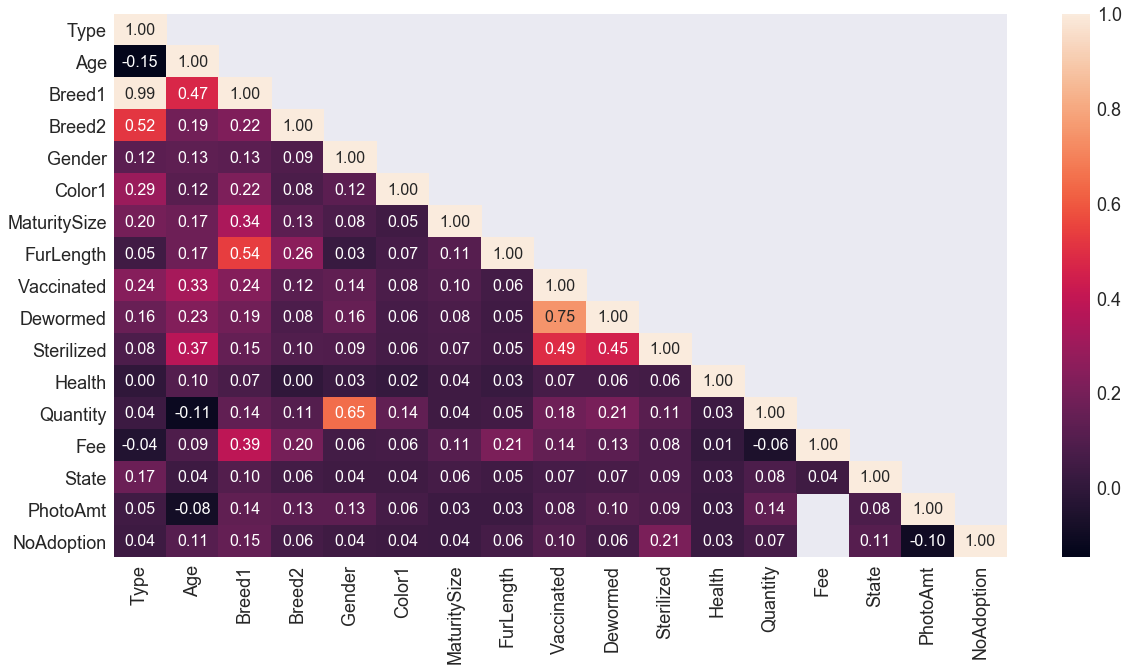

In [44]:
columns = data.columns
corr = pd.DataFrame(index=columns, columns=columns)

for i in range(0, len(columns)):
    for j in range(i, len(columns)):
        
            if i == j:
                corr_factor = 1.0
            
            elif (columns[i] in categorical) and ((columns[j] in categorical)):
                corr_factor =  cramers_v(data[columns[j]], data[columns[i]])
            
            elif (columns[i] in numerical) and (columns[j] in numerical):
                corr_factor, pvalue = ss.pearsonr(data[columns[j]], data[columns[i]])
                if pvalue > 0.05:
                    corr_factor = np.nan
            
            elif (columns[i] in numerical) and ((columns[j] in categorical_multilevel)):
                corr_factor =  correlation_ratio(data[columns[j]], data[columns[i]])
                
            elif (columns[i] in categorical_multilevel) and ((columns[j] in numerical)):
                corr_factor =  correlation_ratio(data[columns[i]], data[columns[j]])
            
            else:
                #if categorical variable is binomial use points biserial
                corr_factor, pvalue = ss.pointbiserialr(data[columns[j]], data[columns[i]])
                
                if pvalue > 0.05:
                    corr_factor = np.nan
                
            corr.loc[columns[j],columns[i]] = corr_factor
    
corr.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,10))
sns.set(font_scale=1.8) 
sns.heatmap(corr,annot=True,fmt='.2f',annot_kws={"size": 16})
plt.show()    


Below we explore the correlation between Age and Breed.

In [45]:
#Verifying which breed's ages are statistically significant different from others:
#Dog ages do not follow a Gaussian distribution so will use Mann-Whitney U Test
from scipy.stats import mannwhitneyu

df_train['Age_Years']=df_train['Age']/12

all_breeds = df_train['Breed1'].unique()
breeds_age_diff = {}#this dict will store the labels of breeds whose age distribution is statistically significant different from others

#the loop below calculates the p_value for each individual breed

for breed in all_breeds:
    data_breed = np.array(df_train.loc[df_train['Breed1'] == breed,'Age_Years'])
    data_other_breeds = np.array(df_train.loc[df_train['Breed1'] != breed,'Age_Years'])
    
    nobs_breed = len(data_breed)
    
    if nobs_breed>= 20:# observed frequency should be at least 20 for Mann-Whitney
        # compare samples
        stat, pval = mannwhitneyu(data_breed, data_other_breeds)
        
        if pval < 0.05:#using 95% confidence interval that breed comes from a different distribution
            breeds_age_diff[breed] = {'p_value':pval}    

print(breeds_age_diff)

{265: {'p_value': 2.76716071970745e-10}, 307: {'p_value': 3.544850079165628e-110}, 266: {'p_value': 2.0332443063340135e-17}, 264: {'p_value': 9.566360379146424e-05}, 218: {'p_value': 0.0009754645087981057}, 285: {'p_value': 8.050810633624997e-10}, 189: {'p_value': 3.979008771715821e-10}, 205: {'p_value': 1.2432856939173801e-77}, 292: {'p_value': 0.0010856002587552502}, 128: {'p_value': 1.1481920633179602e-09}, 213: {'p_value': 2.7225373475697176e-10}, 141: {'p_value': 5.248052968761173e-06}, 173: {'p_value': 0.01388905661341374}, 207: {'p_value': 3.001329861842872e-10}, 119: {'p_value': 7.20654192682273e-11}, 195: {'p_value': 3.173032392894636e-26}, 109: {'p_value': 4.8888690785129065e-42}, 206: {'p_value': 0.0024226571134391512}, 103: {'p_value': 4.503779501731931e-09}, 78: {'p_value': 5.589991859469201e-05}, 20: {'p_value': 1.7335221767022674e-26}, 69: {'p_value': 5.50132992797426e-14}, 179: {'p_value': 2.1086143506706568e-51}, 152: {'p_value': 2.979987230183482e-11}, 75: {'p_value':

In [46]:
#Display age means for each breed found to have been very likely to come from a different distribution
breeds_dict = df_breedlabels.to_dict()['BreedName']

age_by_breeds = df_train.groupby('Breed1')['Age_Years'].mean()
age_by_breeds_df = pd.DataFrame()
age_by_breeds_df['Age Mean']=age_by_breeds.loc[breeds_age_diff.keys()].sort_values()
age_by_breeds_df['BreedName'] = age_by_breeds_df.index.map(breeds_dict)
age_by_breeds_df

,Age Mean,BreedName
Breed1,,
265,0.523516,Domestic Medium Hair
266,0.560379,Domestic Short Hair
307,0.628452,Mixed Breed
292,0.750947,Siamese
264,0.822072,Domestic Long Hair
251,1.014706,British Shorthair
276,1.164216,Maine Coon
285,1.222851,Persian
218,1.248971,Terrier


Generic dog and cat breeds like Domestic Medium Hair, Domestic Short Hair and Mixed Breed and the Siamese tend to be younger than one year. It is harder to label specific breeds for kittens and puppies than it is for adult dogs, so this likely plays a role in the differences in the distribution.
Several breeds of dog tend to be older, this might be due to certain breed temperaments or size changing overtime or people abandoning or losing pets because they are older.

### Are breed traits correlated with higher adoption rates?

In [47]:
df_adoption_traits

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,AllAroundFriendliness_1,HealthGrooming_1,Trainability_1,ExerciseNeeds_1,BreedName_2,Adaptability_2,AllAroundFriendliness_2,HealthGrooming_2,Trainability_2,ExerciseNeeds_2
7,1,Max,78,218,205,1,1,7,0,2,...,4.0,3.0,5.0,5.0,Shih Tzu,3.0,5.0,2.0,3.0,2.0
13,1,Hunter,14,189,0,1,1,2,0,3,...,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
14,1,Benji & Kimi,4,205,218,3,2,7,0,1,...,5.0,2.0,3.0,2.0,Airedale Terrier,2.0,4.0,3.0,5.0,5.0
18,1,Jack,5,128,307,1,7,0,0,2,...,5.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
23,1,Blackie Duo,1,307,141,2,1,0,0,2,...,NaN,NaN,NaN,NaN,Labrador Retriever,3.0,5.0,4.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8116,1,D144(030217),48,83,0,1,5,0,0,1,...,5.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
8117,1,Racer,7,182,0,1,1,2,0,1,...,4.0,3.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
8118,1,Maddie,1,218,307,2,1,2,0,2,...,4.0,3.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
8129,1,Terry,24,179,307,1,2,3,7,2,...,5.0,2.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


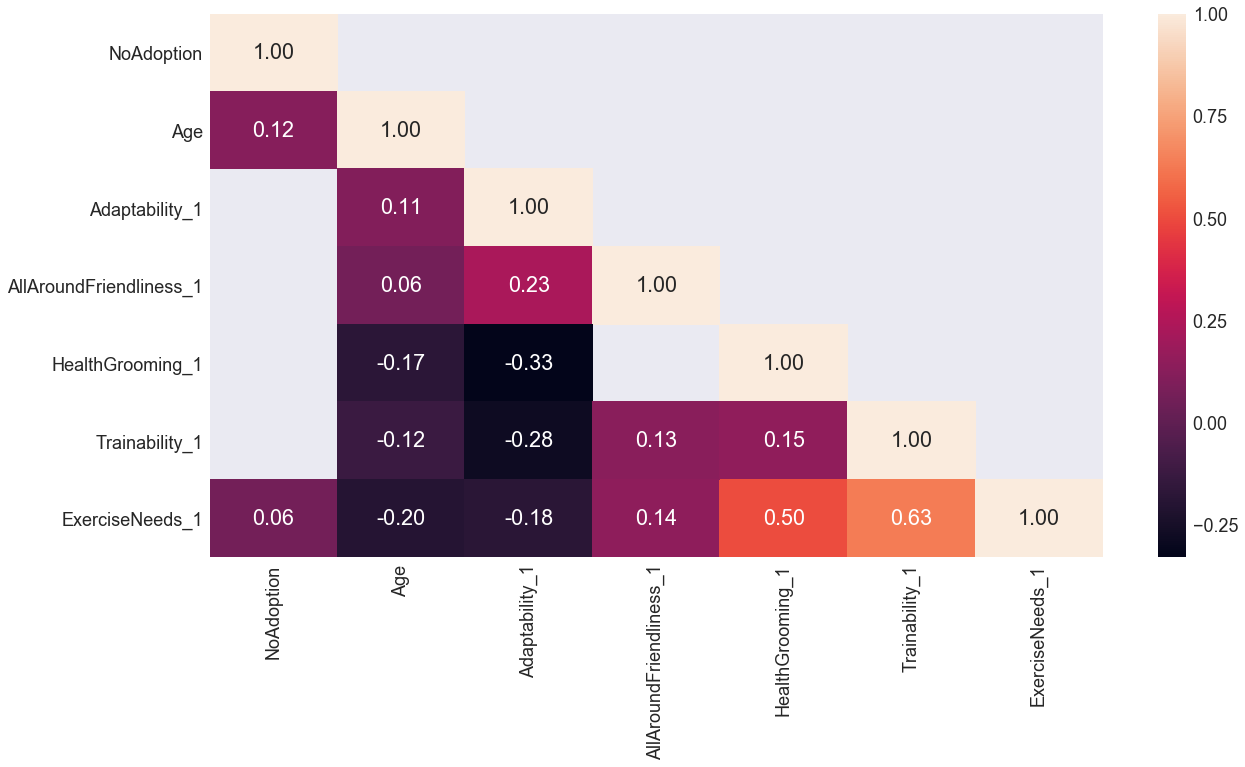

In [48]:
#Among dogs that had breed1 traits available . Dropping all ID features and breed 2 traits
traits_1 = ['NoAdoption','Age','Adaptability_1', 'AllAroundFriendliness_1', 'HealthGrooming_1', 'Trainability_1', 'ExerciseNeeds_1']
data = df_adoption_traits[traits_1].dropna()
targetvariable = 'NoAdoption' 

corr = pd.DataFrame(index=data.columns,columns=data.columns)#initialize empty dataframe to be populated with correlation factors
columns = data.columns

alpha = 0.05

for i in range(0, len(columns)):
    for j in range(i, len(columns)):
            if i == j:
                corr[columns[j]][columns[i]] = 1.0
            if (columns[i] == targetvariable) or (columns[j] == targetvariable):    
                corr_factor, pvalue = ss.pointbiserialr(data[columns[j]], data[columns[i]])
            else:
                corr_factor, pvalue = ss.pearsonr(data[columns[j]], data[columns[i]])
            if pvalue <= alpha:
                corr.loc[columns[j],columns[i]] = corr_factor
    
corr.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,10))
sns.set(font_scale=1.8) 
sns.heatmap(corr,annot=True,fmt='.2f')
plt.show()  

# Machine Learning Model

### Feature Engineering

In [49]:
#Performing t-test on each breed to see if we can limit the number of breeds to those that
#are statistically significant different from others

breeds = df_train['Breed1'].unique()
significant_breeds = {}#this dict will store the labels of breed that are statistically significant different

#the loop below calculates the p_value for each individual breed
for breed in breeds:
    breed_data = df_train.loc[df_train['Breed1'] == breed,'NoAdoption']
    other_data = df_train.loc[df_train['Breed1'] != breed,'NoAdoption']
    stat, p = ttest_ind(breed_data, other_data) 
    
    if breed_data.shape[0]>1:
        if p < 0.05:#using 95% confidence interval, can be adjusted for different values
            significant_breeds[breed] = {'t':stat, 'p_value':p}
    
print(significant_breeds.keys())

C:\Users\isado\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\isado\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\isado\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\isado\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\isado\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


dict_keys([265, 307, 264, 218, 285, 189, 205, 292, 243, 141, 207, 109, 103, 78, 254, 20, 283, 69, 179, 152, 60, 296, 294, 239, 169, 295, 1, 11, 150, 279, 132])


In [50]:
#Calculating adoption averages per breed using information based on Breed1 column
noadoption_averages = df_train[['Breed1','NoAdoption']].groupby('Breed1')['NoAdoption'].mean()
noadoption_averages

Breed1
0      0.400000
1      1.000000
3      1.000000
5      0.500000
7      1.000000
         ...   
303    0.261905
304    0.428571
305    0.375000
306    0.321429
307    0.342669
Name: NoAdoption, Length: 176, dtype: float64

In [51]:
adoption_average = {}

for breed in significant_breeds.keys():
    adoption_average[breed] = noadoption_averages[breed]  

#iterates through the original dataframe and creates a panda series with adoption averages
#for statistically significant different breeds or overall NoAdoption average otherwise

df_train['Breed1NoAdoptionRate'] = df_train['Breed1'].map(adoption_average).fillna(df_train['NoAdoption'].mean())
df_train['Breed2NoAdoptionRate'] = df_train['Breed2'].map(adoption_average).fillna(df_train['NoAdoption'].mean())

### Feature Selection

In [52]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


#Converting animal age from months to years
df_train['Age_Years']= df_train['Age']/12

################Dealing with categorical variables for the logistic regression model#########################################
modified_df = df_train.copy()

#Getting dummies for Color1 and State
#Color 2 has over 4,400 entries with Color=0 (no color specified) so it will be dropped
#Color 3 has over 10,000 entries with Color=0 (no color specified) so it will be dropped
colors_dict = {1: 'Black', 2: 'Brown', 3:'Golden', 4:'Yellow', 5:'Cream', 6:'Gray', 7:'White'}
modified_df['Color1'] = modified_df['Color1'].map(colors_dict)
modified_df = pd.get_dummies(modified_df, prefix=['Color'], columns=['Color1'], drop_first=True)

#Getting dummies and adding labels to States
states_dict = state_labels.set_index('StateID').to_dict()['StateName']
modified_df['State'] = modified_df['State'].map(states_dict)
modified_df = pd.get_dummies(modified_df, prefix=['State'], columns=['State'], drop_first=True)


#Getting dummies for vaccination, deworming and sterilization status
#for feature in ['Vaccinated', 'Dewormed','Sterilized']
modified_df = pd.get_dummies(modified_df, prefix=['Vaccinated', 'Dewormed','Sterilized'], columns= ['Vaccinated', 'Dewormed','Sterilized'], drop_first=True)

#For clarity Type will be encoded as 1 (dogs) or 0 (cats)
modified_df['Type'] = modified_df['Type'].map({1:1, 2:0})

#Gender will be encoded as  (0 = Male, 1 = Female, 0.5 = Mixed if profile represents group of pets)
modified_df['Gender'] = modified_df['Gender'].map({1:0, 2:1, 3:0.5})

#Breed1 and Breed2 will dropped, breed relationships can the observed using the BreedAdoptionRate columns
feature_cols = list(col for col in list(modified_df.columns) if col not in ['Age','Name', 'Breed1', 'Breed2', 'Color2', 'Color3','RescuerID', 'Description', 'PetID', 'AdoptionSpeed','NoAdoption'])

scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(modified_df[feature_cols]), columns = feature_cols)


logit = sm.Logit(modified_df['NoAdoption'], features_scaled)

result = logit.fit()

print (result.summary())

Optimization terminated successfully.
         Current function value: 0.644462
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             NoAdoption   No. Observations:                14993
Model:                          Logit   Df Residuals:                    14956
Method:                           MLE   Df Model:                           36
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                -0.08699
Time:                        15:31:15   Log-Likelihood:                -9662.4
converged:                       True   LL-Null:                       -8889.2
                                        LLR p-value:                     1.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Type                     -0.1312      0.021     -6.361      0.000      -0.172      -0.

Maturity Size, VideoAmount all had high p_values. Some color, state, deworming and sterilization sub-categories had high p-values while others did not so we will keep them all as features in our logistic regression model.

In [53]:
#Creating feature sets for 10% and 5% significance levels using the resulting p-values above
features_p_value10 = ['Type','Age', 'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 
                      'Health', 'Quantity', 'Fee', 'State', 'PhotoAmt', 'Breed1NoAdoptionRate',
                      'Breed2NoAdoptionRate', 'Color1','State']
features_p_value5 = ['Type', 'Age', 'Gender', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
                     'Health', 'Quantity', 'Fee', 'State', 'PhotoAmt', 'Breed1NoAdoptionRate',
                     'Breed2NoAdoptionRate', 'Color1','State']#same features as 10% significance level

In [54]:
#Checking for Multicolinearity between variables using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Dummy encoded categorical variables are removed from vif calculations
df_vif = features_scaled.iloc[:,:-25]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns
vif.round(1)

,VIF Factor,features
0,1.2,Type
1,1.0,Gender
2,1.1,MaturitySize
3,1.1,FurLength
4,1.0,Health
5,1.0,Quantity
6,1.1,Fee
7,1.1,VideoAmt
8,1.1,PhotoAmt
9,1.2,Age_Years


All Variance Inflation factors were well below 5, so these features do not have strong colinearity.

In [55]:
print('\nODDS RATIOS\n')
print (np.exp(result.params))


ODDS RATIOS

Type                     0.877049
Gender                   1.046902
MaturitySize             1.024239
FurLength                0.951204
Health                   1.056471
Quantity                 1.202138
Fee                      1.079573
VideoAmt                 1.006545
PhotoAmt                 0.816535
Age_Years                1.245263
Breed1NoAdoptionRate     1.529870
Breed2NoAdoptionRate     1.072892
Color_Brown              1.012292
Color_Cream              0.959081
Color_Golden             0.989162
Color_Gray               0.972639
Color_White              0.961090
Color_Yellow             1.020174
State_Kedah              1.057266
State_Kelantan           1.022978
State_Kuala Lumpur       1.150694
State_Labuan             1.015020
State_Melaka             1.153114
State_Negeri Sembilan    1.091512
State_Pahang             1.025152
State_Perak              1.059460
State_Pulau Pinang       1.110175
State_Sabah              1.014307
State_Sarawak            1.082485


The odds ratio highest values are for the Breed1 Adoption rates, followed by Sterilization, Age and Quantity.
While the odds ratio on the normalized feature set above allows us to compare feature importance it loses some of it's interpretability. For instace if we wish to assess how much higher on average an animal's odds are at not getting adopted for each year of age we need to calculate the Odds Ratio using the raw (non-normalized) feature data. This calculation is shown below:

In [56]:
logit = sm.Logit(modified_df['NoAdoption'], modified_df[feature_cols])

result = logit.fit()
print('\nODDS RATIOS\n')
print (np.exp(result.params))

Optimization terminated successfully.
         Current function value: 0.541149
         Iterations 6

ODDS RATIOS

Type                       0.818141
Gender                     1.060910
MaturitySize               0.930654
FurLength                  0.769427
Health                     0.818323
Quantity                   1.133322
Fee                        1.000556
VideoAmt                   1.040193
PhotoAmt                   0.911615
Age_Years                  1.123850
Breed1NoAdoptionRate     187.928792
Breed2NoAdoptionRate       0.143250
Color_Brown                0.985126
Color_Cream                0.724472
Color_Golden               0.860200
Color_Gray                 0.777515
Color_White                0.727917
Color_Yellow               1.060476
State_Kedah                1.136782
State_Kelantan             1.503461
State_Kuala Lumpur         0.812516
State_Labuan               1.133953
State_Melaka               2.350687
State_Negeri Sembilan      1.207667
State_Pahang        

For every year of age, the odds that a dog will not be adopted increases on average by 13.4%.

### Logistic Regression

In [57]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, auc

df_logreg = pd.get_dummies(df_train[features_p_value10], columns=['Color1','State','Vaccinated','Dewormed','Sterilized'],drop_first=True)

X = df_logreg
y = df_train['NoAdoption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Setup the hyperparameter grid
c_space = [0.0001, 0.001, .01, .1, .5, 1, 10, 100]
#c_space = np.logspace(-5, 8, 15)

#Finding best set of features using l1 penalization 

C_features_dict={}

for c in c_space:
    features = []
    # Instantiate a logistic regression classifier: logreg
    logreg = LogisticRegression(penalty='l1', C=c)
    # Fit it to the data
    logreg.fit(X_train,y_train)

    # Scoring with AUC
    score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
    
    
    print ('C value:',c,' SCORE:',score)
    print('_______________________________')
    
    for idx, coefficient in enumerate(logreg.coef_[0]):
        if coefficient != 0:
            features.append(X_train.columns[idx])
            
    C_features_dict[c]=features

print('Features sets:', C_features_dict)

C value: 0.0001  SCORE: 0.4836155120911134
_______________________________
C value: 0.001  SCORE: 0.5972279983252233
_______________________________
C value: 0.01  SCORE: 0.6875551075410691
_______________________________
C value: 0.1  SCORE: 0.7119869677042542
_______________________________
C value: 0.5  SCORE: 0.7149187064813153
_______________________________
C value: 1  SCORE: 0.7151927928308299
_______________________________
C value: 10  SCORE: 0.7152775871956991
_______________________________
C value: 100  SCORE: 0.7144321064538715
_______________________________
Features sets: {0.0001: ['Age', 'Fee', 'PhotoAmt'], 0.001: ['Age', 'FurLength', 'Fee', 'PhotoAmt'], 0.01: ['Type', 'Age', 'FurLength', 'Quantity', 'Fee', 'PhotoAmt', 'State_41326', 'State_41326', 'Sterilized_2'], 0.1: ['Type', 'Age', 'Gender', 'FurLength', 'Health', 'Quantity', 'Fee', 'PhotoAmt', 'Breed1NoAdoptionRate', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_7', 'State_41326', 'State_41330', 'State_41

In [58]:
feature_set1l1 = C_features_dict[10] #score of 0.7153
feature_set2l1 = C_features_dict[1]#score of 0.7151
print (feature_set1l1,'\n', feature_set2l1)

['Type', 'Age', 'Gender', 'FurLength', 'Health', 'Quantity', 'Fee', 'PhotoAmt', 'Breed1NoAdoptionRate', 'Breed2NoAdoptionRate', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415', 'State_41325', 'State_41326', 'State_41327', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_2', 'Dewormed_3', 'Sterilized_2', 'Sterilized_3'] 
 ['Type', 'Age', 'Gender', 'FurLength', 'Health', 'Quantity', 'Fee', 'PhotoAmt', 'Breed1NoAdoptionRate', 'Breed2NoAdoptionRate', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_4140

The 2 best performing models have a slightly different set of features with non-zero coefficients. We use both sets to create a Logistic Regression Model below, now using L2 penalization.

(After running both feature sets with L2 penalization, feature set 2 shown below had a slightly better performance over feature set 1.)

In [59]:
#Using feature_set1
X = df_logreg[feature_set2l1]
features_list = X.columns
y = df_train['NoAdoption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Setup the hyperparameter grid
c_space = [0.0001, 0.001, .01, .1, .5, 1, 10]
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

# Fit it to the data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best AUC-ROC score is {}".format(logreg_cv.best_score_))

# calculate brier score
brier_loss = brier_score_loss(y_test, logreg_cv.predict_proba(X_test)[:, 1])
print("Brier score is {}".format(brier_loss))

#Storing false and true positive rates to plot ROC later
lr_fpr, lr_tpr, _ = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:, 1])

Tuned Logistic Regression Parameters: {'C': 10}
Best AUC-ROC score is 0.7017912025792453
Brier score is 0.17821321113593028


### Random Forest

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Splitting target and features

df_train['random'] = np.random.random(size = df_train.shape[0]) #adding a random column for a baseline on feature importances
X = df_train[features_p_value5]
y = df_train['NoAdoption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


#Instantiate the model
#rfm = RandomForestClassifier()

#Tuning parameters and performing cross-validation
# Setup the hyperparameter grid
#n_estimators = np.arange(50, 400, 50)#number of trees in Forest
#max_depth = np.arange(1,8)#depth of trees
#param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

# Instantiate the GridSearchCV object: rf_cv
#rf_cv = GridSearchCV(rfm, param_grid, cv=5, scoring='roc_auc')

#Fitting the model
#rf_cv.fit(X_train, y_train)

#print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_)) 
#print("Best score is {}".format(rf_cv.best_score_))

#############OUTPUT FROM GRIDSEARCH##########################################
#Tuned Random Forest Parameters: {'max_depth': 7, 'n_estimators': 200}
#Best score is 0.7675709053293787
###############################################################################

#Instantiate the model with best parameters acquired from GridCV Search
rfm = RandomForestClassifier(max_depth=7, n_estimators=200)
#Fitting the model
rfm.fit(X_train, y_train)


# Scoring with AUC
print('ROC AUC score:', roc_auc_score(y_test, rfm.predict_proba(X_test)[:,1]))

# calculate brier score
brier_loss = brier_score_loss(y_test, rfm.predict_proba(X_test)[:, 1])
print("Brier score is {}".format(brier_loss))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rfm.predict_proba(X_test)[:, 1])

ROC AUC score: 0.7658106306097101
Brier score is 0.1683472550886043


#### Random Forest Feature Importance

In [61]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.set(font_scale=1.4)
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 16)

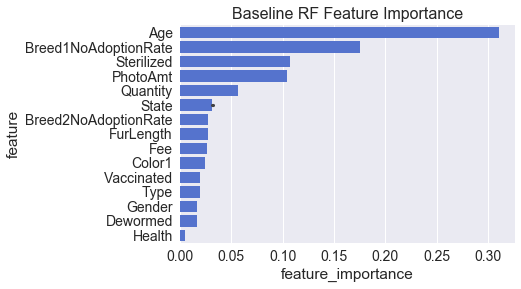

In [62]:
#First we use scikit-learn's default feature importance
baseline_imp = imp_df(X_train.columns, rfm.feature_importances_)
var_imp_plot(baseline_imp,'Baseline RF Feature Importance')

In [63]:
from sklearn.base import clone 

#extracted from https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
#This function drops one columns at a time and calculates the gain/loss in model predictive capability 
#according to desired metric

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):

    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)

    # set random_state for comparability
    model_clone.random_state = random_state

    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = roc_auc_score(y_train, model_clone.predict_proba(X_train)[:,1])

    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)

    for col in X_train.columns:

        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        #drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        drop_col_score= roc_auc_score(y_train, model_clone.predict_proba(X_train.drop(col, axis = 1))[:,1])
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X_train.columns, importances)

    return importances_df

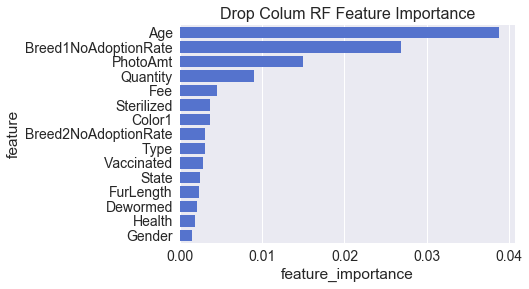

In [64]:
feature_imp = drop_col_feat_imp(rfm, X_train, y_train, random_state = 42)
var_imp_plot(feature_imp,'Drop Colum RF Feature Importance')

### Gradient Boosting

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

X = df_train[features_p_value5]
y = df_train['NoAdoption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#############Random Search CV#################################

#n_estimators = np.arange(100,600,100)
#max_depth = [1,2,4,8]
#learning_rate = [.05,.1,.2,.5,1]

#param_dist = {'n_estimators': n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate}

#gbm = GradientBoostingClassifier()
# Instantiate the RandomSearchCV object: 
#gbm_cv = RandomizedSearchCV(gbm, param_distributions = param_dist, cv=5, scoring='roc_auc', n_iter=30)

#Fitting the model
#gbm_cv.fit(X_train, y_train)

#print("Tuned Random Forest Parameters: {}".format(gbm_cv.best_params_)) 
#print("Best score is {}".format(gbm_cv.best_score_))

#Tuned Random Forest Parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
#Best score is 0.7748282122462766

#############End of Random Search CV#################################


gbm = GradientBoostingClassifier(n_estimators= 100, max_depth= 4, learning_rate= 0.1, random_state=42).fit(X_train, y_train)
print('Best ROC AUC:', roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

# calculate brier score
brier_loss = brier_score_loss(y_test, gbm.predict_proba(X_test)[:, 1])
print("Brier score is {}".format(brier_loss))

gb_fpr, gb_tpr, _ = roc_curve(y_test, gbm.predict_proba(X_test)[:, 1])

Best ROC AUC: 0.7746090135354324
Brier score is 0.16322820948605687


## Model Evaluation and Threshold

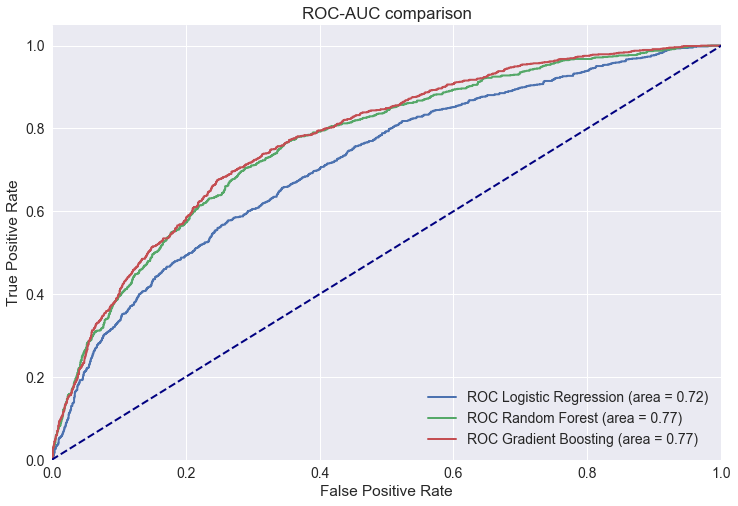

In [66]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12,8))

for fpr, tpr, model in [(lr_fpr,lr_tpr,'Logistic Regression'),(rf_fpr,rf_tpr,'Random Forest'),(gb_fpr,gb_tpr,'Gradient Boosting')]:
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='ROC '+ model + ' (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC comparison')
plt.legend(loc="lower right")
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix, fbeta_score

#Using the Random Forest Model the confusion matrix is generated

X = df_train[features_p_value5]
y = df_train['NoAdoption']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

confusion_rfm = confusion_matrix(y_test, rfm.predict(X_test))
print(confusion_rfm)

[[2586  108]
 [ 823  232]]


The purpose of the model is to try to identify animals that have a higher likelihood of not getting adopted. If a Type I error occurs (false positive) and an animal mistakenly gets labeled as "not likely to be adopted" and gets additional exposure to potential adopters as a result, there is no downside to that animal. However, because rescue organizations resources are limited this additional attention or spot at a foster home might take away from animal that is truly at risk. 
If a Type II error occurs (false negative) an animal that is likely to not get adopted might not get additional attention and could potentially end up getting euthanized.

In [68]:
from sklearn.metrics import classification_report

def precision_recall(model, X_test, y_test, threshold, beta = 0.5):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    print(threshold,'\n', matrix)
    
    tn = matrix[0,0]# pets that were predicted to get adopted and did
    tp = matrix[1,1]# pets that were predicted not to get adopted and didn't
    fp = matrix[0,1]# pets that were predicted not to get adopted but did
    fn = matrix[1,0]# pets that were predicted to get adopted but didn't
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [69]:
y_pred = (rfm.predict_proba(X_test)[:,1] >= 0.38).astype(bool)

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

      False       0.80      0.87      0.83      2694
       True       0.57      0.46      0.51      1055

avg / total       0.74      0.75      0.74      3749



In [70]:
threshold_df = pd.DataFrame(columns=['Precision','Recall','F0.5_measure'])

for threshold in np.arange(0.1,.9,.02):
    
    threshold_df.loc[threshold] = precision_recall(rfm, X_test, y_test, threshold)
    
      
print(threshold_df)

0.1 
 [[  74 2620]
 [   1 1054]]
0.12000000000000001 
 [[ 214 2480]
 [  10 1045]]
0.14 
 [[ 437 2257]
 [  28 1027]]
0.16000000000000003 
 [[ 690 2004]
 [  48 1007]]
0.18000000000000002 
 [[1018 1676]
 [ 104  951]]
0.2 
 [[1307 1387]
 [ 156  899]]
0.22000000000000003 
 [[1496 1198]
 [ 196  859]]
0.24000000000000002 
 [[1677 1017]
 [ 231  824]]
0.26 
 [[1803  891]
 [ 278  777]]
0.28 
 [[1925  769]
 [ 319  736]]
0.30000000000000004 
 [[2002  692]
 [ 374  681]]
0.32000000000000006 
 [[2092  602]
 [ 406  649]]
0.3400000000000001 
 [[2161  533]
 [ 457  598]]
0.3600000000000001 
 [[2254  440]
 [ 511  544]]
0.38 
 [[2332  362]
 [ 569  486]]
0.4 
 [[2404  290]
 [ 626  429]]
0.42000000000000004 
 [[2455  239]
 [ 673  382]]
0.44000000000000006 
 [[2486  208]
 [ 714  341]]
0.4600000000000001 
 [[2528  166]
 [ 738  317]]
0.4800000000000001 
 [[2559  135]
 [ 774  281]]
0.5000000000000001 
 [[2586  108]
 [ 823  232]]
0.5200000000000001 
 [[2614   80]
 [ 878  177]]
0.54 
 [[2643   51]
 [ 925  130]]
0.

C:\Users\isado\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


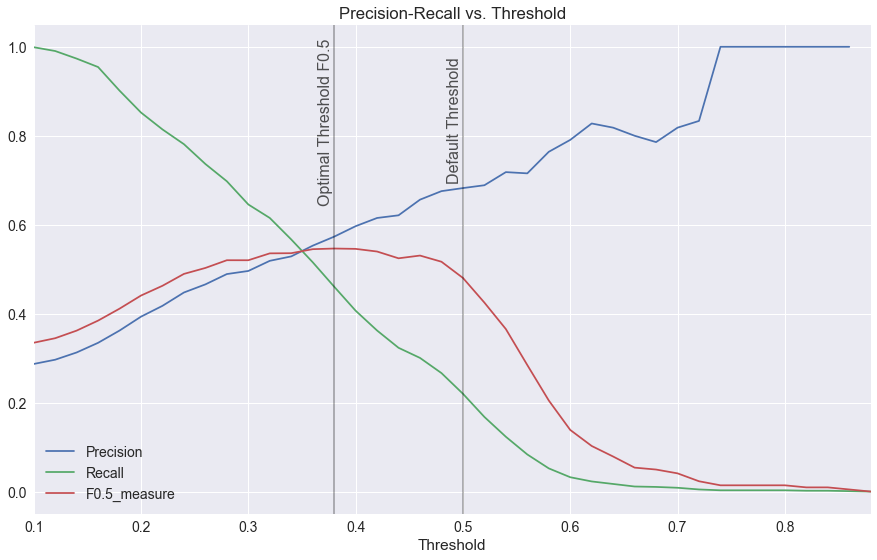

In [71]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold')
ax.axvline(0.38, color='black', alpha=0.3)
ax.text(.365,.65,'Optimal Threshold F0.5',rotation=90, alpha=0.8, fontsize=16)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8,fontsize=16);

Because we want to minimize the number of Type II errors the original optimal threshold was selected calculating the F measure with a beta value of 2 but the resulting best threshold identified over 40% of animals as being at risk of not getting adopted, which is not feasible considering rescue organization resources and space for animal intake are limited. Assuming we can prioritize ~ 25% of animals, the F0.5 measure was used instead, and the resulting best threshold is 0.38 which identified 24.7% of animals of being at risk.
While selecting the appropriate threshold is important for binary classification output, the raw ranked probability value for each prediction would be more useful asset to animal rescue organizations with limited amount of space and resources. Using the raw probability output instead, the Gradient Boosting model has a good Brier score at 0.17.